# Solid Domestic Waste Classification Demo Notebook

- This notebook is designed for the reader to familiarize with the techniques I used to build an Image Classifier using classical image processing techniques and machine learning algorithms.
- In this stage of the project, the model classifies whether a garbage image is made of metal or cardboard. 
- I encourage you to test the classifier by yourself. Currently, we are working on exporting the model and adding it to a web page in which people can test it. Meanwhile, you can download the notebook and the data and follow the instructions listed in the notebook

# Imports

Here are all the libraries I use in the project

In [1]:
import os
import errno
import shutil
import zipfile
import timeit

import cv2

import numpy as np
import pandas as pd
import scipy
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, NMF

from sklearn.model_selection import (cross_validate, StratifiedKFold, 
                                     train_test_split, learning_curve, 
                                     GridSearchCV)
from sklearn.metrics import (accuracy_score, plot_roc_curve, auc, 
                               confusion_matrix, roc_auc_score, roc_curve)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


# Setting GPUs

If you work with google colab, this may help you to grasp how the gpu works and how to use it in your favor.

In [2]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Found GPU at: /device:GPU:0
Num GPUs Available:  1
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.7166731880000157
GPU (s):
0.047372335000005705
GPU speedup over CPU: 78x


# Manage Files

- This piece of code brings the zip folders stored in my drive and unzips the images in a folder where they can be manipualted. 
- I chose this process because is the fastest way of importing large sets of images and storing them in a local environment.
- Here you can find both bash and python versions of performing the operation
- If you are testing the model by yourself you can replace the zip folder locations to the ones in which you stored them.

In [3]:
%%bash

# Remove data directory
rm -r data

# Creating data directory
mkdir data

# Copying, unzipping and removing zip files
cp /content/drive/MyDrive/sdw_classification/datasets/not_processed/metal.zip /content/
unzip -q /content/metal.zip -d /content/data/ 
rm /content/metal.zip

cp /content/drive/MyDrive/sdw_classification/datasets/not_processed/cardboard.zip /content/
unzip -q /content/cardboard.zip -d /content/data
rm /content/cardboard.zip

# Make sample images directory
mkdir sample_images

rm: cannot remove 'data': No such file or directory


In [5]:
def bring_data(path_list, root='data'):
    """
    Brings zip folders and unzips them into the specified root. 
    Output:
        path_list: list of paths to each of the compressed folders stored
            in the drive.
        root: path in which the compressed folder will be unzipped.
    """

    # Delete directories to avoid over-riding files
    try:
        shutil.rmtree(root)
    except Exception:
        print('Not found')

    # Create root directory
    os.mkdir(root)
    
    # Copying zip files
    for filepath in path_list:
        
        # Extract Category Names
        category = os.path.basename(filepath)

        # Copy zip files
        shutil.copy(filepath,root)

        # Unzip the files
        local_zip_folder = os.path.join(root,category)
        with zipfile.ZipFile(local_zip_folder, 'r') as zip_ref:
            zip_ref.extractall(root)

        # Remove zip folder
        os.remove(local_zip_folder)

# Loading and Preprocessing

- In this cells I have defined the functions that allow me to read the images and then preprocessed them with the specified procedures.
- The functions are built using OpenCV methods and algorithms (Read image, change color, bluring, edge detection)  

In [6]:
def extract_edges(img):

    """
    Extracts the edges of the image using the canny algorithm.

    Args:
        img: image.

    Outputs:
        edged: highlighted edges image.
    """

    # Blurring 
    blurred = cv2.bilateralFilter(img,15,150,150)

    # Edge Detection
    v = np.median(blurred)
    sigma = 0.33

    lower = int(max(0,(1-sigma)*v))
    upper = int(min(255,(1+sigma)*v))

    img = np.uint8(img)

    edged = cv2.Canny(img,lower,upper)

    return edged

def make_cut(img, edged):

    """
    Cuts the image on the corresponding axis.

    Args:
        img: image.
        edged: highlighted edges image.

    Output:
        img: cutted image.
        edged: cutted highlighted edges image.
    """

    index = 0
    for i in range(edged.shape[0]):
        aux = np.sum(edged[i])
        if aux != 0:
            index = i
            break

    if index != 0:
        img = img[index-1:]
        edged = edged[index-1:]
    
    return img, edged

def center_image(img):

    """
    Centers the image taking into account the borders of the object.

    Args:
        img: image that is going to be centered.

    Outputs:
        img: centered image.
        edged: centered image with highlighted borders.
    """

    edged = extract_edges(img)

    # Superior cut
    img, edged = make_cut(img, edged)

    edged_trans = edged.transpose()
    img_trans = img.transpose()

    # Left cut
    img_trans, edged_trans = make_cut(img_trans, edged_trans)

    edged_trans_flip = np.flip(edged_trans)
    img_trans_flip = np.flip(img_trans)

    # Right cut
    img_trans_flip, edged_trans_flip = make_cut(img_trans_flip, edged_trans_flip)

    edged_trans_flip_trans = edged_trans_flip.transpose()
    img_trans_flip_trans = img_trans_flip.transpose()

    # Inferior cut
    img_trans_flip_trans, edged_trans_flip_trans = make_cut(img_trans_flip_trans,
                                                            edged_trans_flip_trans)
    
    img = np.flip(img_trans_flip_trans.transpose()).transpose()
    edged = np.flip(edged_trans_flip_trans.transpose()).transpose()

    return img, edged

def preprocessing(img, resize, blur, grayscale, rescale, edges, center):

    """
    Applies the specified functions to the image.

    Args:
        img: image to be preprocessed.
        resize: reference size to give to the image.
        blur: Boolean marker that indicates to blur the image.
        grayscale: Boolean marker that indicates to convert the image to 
            grayscale.
        recale: Boolean marker that indicates to rescale image pixel values.
        edges: Boolean marker that indicates to extract edges of the image.
        center: Boolean marker that indicates to center the image.

    Output:
        img: preprocessed img
    """
    
    # Convert it to GrayScale or to RGB
    if grayscale:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # cv2.imwrite('metal_grayscale.jpg',img)

        # Recale Values between 0-1
        if rescale and not edges:
            img_res = img/255
            # cv2.imwrite('metal_rescaled.jpg', img_res)

    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if center:
        img, edged = center_image(img)
        # cv2.imwrite('metal_centered.jpg', img)
        # cv2.imwrite('metal_edges.jpg', edged)
        if edges:
            img = edged

    # Edges and blur
    if edges and not center:
        img = extract_edges(img)
    elif blur:
        img = cv2.bilateralFilter(img,15,50,150)
        # cv2.imwrite('metal_blurred.jpg', img)

    # Resize it to certain dimensions
    if resize[0] != 0 and resize[1] != 1:
        img = cv2.resize(img, resize, interpolation = cv2.INTER_AREA)
        # cv2.imwrite('metal_resized.jpg', img)

    return img

def load_images(root = 'data', resize = (0,0), blur = False, grayscale = False,
                rescale = False, edges = False, center = False):
    
    """
    This function reads the images and stores them into a dictionary.

    Args:
        root: path to the data/image directory
        resize: reference size to give to the image.
        blur: Boolean marker that indicates to blur the image.
        grayscale: Boolean marker that indicates to convert the image to 
            grayscale.
        recale: Boolean marker that indicates to rescale image pixel values.
        edges: Boolean marker that indicates to extract edges of the image.
        center: Boolean marker that indicates to center the image.

    Output:
        images: dictionary of images with each label as key of the dictionary.

    """
    
    with tf.device('/device:GPU:0'):

        images = {}

        for label in os.listdir(root):
            label_path = os.path.join(root, label)
            category = []

            for image in os.listdir(label_path):
                # Read Image
                img = cv2.imread(os.path.join(label_path, image))
                img = np.float32(img)

                img = preprocessing(img, resize, blur, grayscale, rescale, 
                                    edges, center)

                if img is not None:
                    category.append(img)

            images[label] = category

    return images

def load_sample_images(root, resize = (0,0), blur = False, grayscale = False,
                rescale = False, edges = False, center = False):
    
    """
    Reads specified image and plots the raw and preprocessed version of it.

    Args:
        root: path to the image.
        resize: reference size to give to the image.
        blur: Boolean marker that indicates to blur the image.
        grayscale: Boolean marker that indicates to convert the image to 
            grayscale.
        recale: Boolean marker that indicates to rescale image pixel values.
        edges: Boolean marker that indicates to extract edges of the image.
        center: Boolean marker that indicates to center the image.

    Outputs:
        img: preprocessed image.
    """
    
    # Read Image
    img = cv2.imread(root)

    # Plot image before processing
    plt.imshow(img)
    plt.title('Raw Image')
    plt.show()
    img = np.float32(img)

    img = preprocessing(img, resize, blur, grayscale, rescale, edges, center)

    # Plot image after processing
    plt.imshow(img)
    plt.title('Processed Image')
    plt.show()

    return img

# Bag of Features

- This is a basic approach to the BoF method. The objective of performing this is two obtain a more robust feature vector that is invariant to translation.
- Applying this technique allow the models to understand the contents of the image regardless the order in which the features appear. The prediction will be based solely in the repetition of the identified characteristics.
- This method is based on a very popular method called Bag of Words widely used in NLP tasks. As I said, this is a basic approach, there exist more complex versions of the method which use techniques like SURF or SIFT for feature extraction. I encourage you to look up for literature and study similar approaches. You can find them like Bag of Visual Words as well. 

In [7]:
def extract_patches(img, patch_size, step_size, include_empty_patches=False):

    """
    Extracts patches of each image, flattens it, and adds it to a list.

    Args:
        img: image.
        patch_size: size of the squared patch.
        step_size: specified step of the mask that will run through the image.
        include_empty_patches: Boolean for including patches with missing 
            information.

    Output:
        patches: list flattened image patches.
    """

    with tf.device('/device:GPU:0'):
        patches = []
        for y in range(0, img.shape[0]-patch_size+1, step_size):
            for x in range(0, img.shape[1]-patch_size+1, step_size):
                patch = img[y:y+patch_size,x:x+patch_size]
                if patch.shape==(patch_size, patch_size) and \
                                    (include_empty_patches or np.sum(patch)!=0):
                    patches.append(patch)
    return patches

def get_visual_dictionary(X, patch_size, step_size, dict_size):

    """
    Creates dictionary of specified size of features using the KMeans algorithm.

    Args:
        X:
        patch_size: size of the squared patch.
        step_size: specified step of the mask that will run through the image.
        dict_size: size of the dictionary (number of clusters created by the 
            algorithm).

    Outputs:
        km.cluster_centers_: visual dictionary of features.
    """

    with tf.device('/device:GPU:1'):
        patches = []
        for img in X:
            patches += [i.reshape(patch_size**2) for i in extract_patches(img, 
                                                        patch_size, step_size)]

        cinit = np.zeros((dict_size, patch_size**2))
        km = KMeans(n_clusters=dict_size, init=cinit, n_init=1, n_jobs=-1)
        km.fit(patches)
        return km.cluster_centers_

def get_closest(patch, dictionary):

    """
    Get the closes feature to the one identified in a patch.

    Args:
        patch: patch of the image.
        dictionary: visual dictionary of features.

    Outputs:
        r: index of the identified feature in the dictionary.
    """

    with tf.device('/device:GPU:2'):
        dmin, r = np.inf, None
        for i, vw in enumerate(dictionary):
            distance = scipy.linalg.norm(patch-vw)
            if distance<dmin:
                dmin = distance
                r = i
    return r

def get_histogram(img, patch_size, step_size, dictionary):

    """
    Creates the feature vector (histogram) of each image.

    Args:
        img: image to get the dictionary.
        patch: patch of the image.
        step_size: specified step of the mask that will run through the image.
        dictionary: visual dictionary of features.

    Output:
        np.array(h)*1./np.sum(h): normalized histogram.
    """

    with tf.device('/device:GPU:3'):
        patches = [i.flatten() for i in extract_patches(img, patch_size, step_size)]
        
        vws = np.array([get_closest(patch, dictionary) for patch in patches])
        h = [np.sum(vws==i) for i in range(len(dictionary))]

    return np.array(h)*1./np.sum(h)

# Run Code

# Preprocessing Configurations

- In here you can you can manipulate the different preprocessing techniques applied to the images
- Then the images will be load and processed.
- The patch and step size are parameters used within the BoF. You can observe the impact that they make by running the last cell of the notebook. You cannot run it solely, you have to run the whole notebook in order for it to work.


In [8]:
# Preprocessing
dims = (75, 75)
grayscale = True
blur = True
rescale = False
center = True
edges = False

# BoF
patch_size, step_size = 10,3

In [9]:
# Load images
image_dict = load_images(resize = dims, grayscale = grayscale, blur =  blur, 
                         rescale = rescale, center = center, edges = edges)
image_list = []
labels = []
for key, value in image_dict.items():
    image_list.extend(value)
    cat = [key]*len(value)
    labels.append(cat)

# Balancing dataset randomly
n = 403
cont = 0
balanced_image_list = []
balanced_label_list = []
for values in image_dict.values():
    images = sample(values, n)
    balanced_image_list.extend(images)
    label = [cont]*n
    balanced_label_list.extend(label)
    cont += 1

y = pd.DataFrame(balanced_label_list)

# Bag of Features
vdict = get_visual_dictionary(balanced_image_list, patch_size, step_size, 60)
Xh = [get_histogram(img, patch_size, step_size, vdict) for img in balanced_image_list]
Xh = np.array(Xh)

Xh = pd.DataFrame(Xh)
Xh.fillna(0, inplace = True)

# Model

- Here you can train the model that you want. 
- I decided to train a Support Vector Machine using the hyperparameters selected after running a GridSearch

In [10]:
# Model Training
model = SVC()

hyperparameters = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01, 0.001],'kernel': ['rbf', 'sigmoid']}
skf = StratifiedKFold(n_splits = 5)

clf = GridSearchCV(model, hyperparameters, cv  = skf, scoring = 'roc_auc')
clf.fit(Xh, y[0])

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

# Sample Image

- Now that you are all set you can look for any image in google and upload it to the environment. 
- I suggest you to google objects like the following: Coca Cola Can, Tin Can, Milk Cardboard, Juice Cardboard, or use similar queues and objects.
- After you upload the image just replace the root and run the cells to make the prediction. 

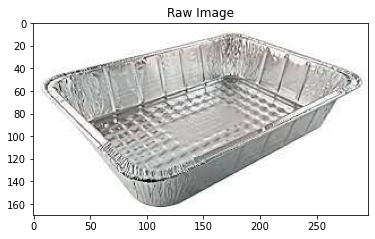

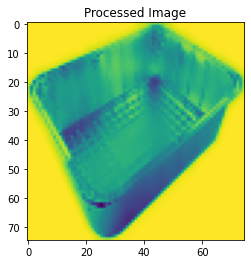

In [11]:
root = '/content/sample_images/metal1.jpg'

# Loading and preprocessing
sample_image = load_sample_images(root, resize = dims, grayscale = grayscale, blur =  blur, 
                         rescale = rescale, center = center, edges = edges)

# Extracting BoF
X_sample_image = [get_histogram(sample_image, patch_size, step_size, vdict)]
X_sample_image = pd.DataFrame(X_sample_image)

In [12]:
# Prediction
labels = {0:'Metal',1:'Cardboard'}
prediction = labels[clf.predict(X_sample_image)[0]]

print('The SVM Classified the image as: %s' % prediction)

The SVM Classified the image as: Metal


# Image Patches

- This piece of code allows you to visualize the image patches that are being fed to the BoF. Each patch is collected and a visual dictionary of characteristics is built with it. 

patch extraction with empty patches 484
without empty patches 484


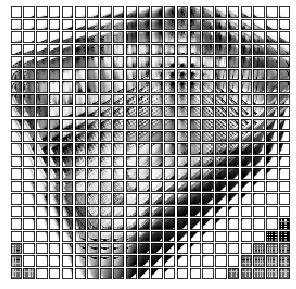

In [13]:
patch_size, step_size = 10,3
p = extract_patches(sample_image, patch_size, step_size, include_empty_patches=True)
print ("patch extraction with empty patches", len(p))
pe = extract_patches(sample_image, patch_size, step_size)
print ("without empty patches", len(pe))
plt.figure(figsize=(5,5))
s = np.sqrt(len(p))
for i in range(len(p)):
    plt.subplot(s,s,i+1)
    plt.imshow(p[i], cmap = plt.cm.Greys_r, interpolation="nearest")
    plt.xticks([]); plt.yticks([])

#Thank you for reading!

This is a work in progress. Currently, I am working in building a classifier using modern techniques such as Transfer Learning, Object Detection, and using GANs for image augmentation. 

I encourage you to check tatata.ipynb, in there I have the structure with which I found the combination of processing techniques and machine learning algorithms that have the best performance. The model evaluation pipeline includes HyperParameter Tuning, Learning Curves, ROC Curves, Cross Validation Results, and an excelent rutine to perform and store experiments.   